<a href="https://colab.research.google.com/github/globalpie271/mask_classification/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
MODELS_PATH

'gdrive/My Drive/Colab Notebooks/face_recognition/data/models/'

In [ ]:
!cd gdrive/My\ Drive/Colab\ Notebooks/face_recognition/data/models/
!ls gdrive/My\ Drive/Colab\ Notebooks/face_recognition/data/models/

facenet_keras.h5	 triplet_model_1_last.h5  triplet_model.h5
triplet_model_1_best.h5  triplet_model_best.h5	  triplet_model_last.h5


In [ ]:
!pwd
!find gdrive/My\ Drive/Colab\ Notebooks/face_recognition/data/images/masks/train -type f | wc -l
!find gdrive/My\ Drive/Colab\ Notebooks/face_recognition/data/images/masks/test -type f | wc -l
!find gdrive/My\ Drive/Colab\ Notebooks/face_recognition/data/images/masks/validation -type f | wc -l

/content
10440
992
800


In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1MB 4.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import keras
from keras import models, layers
from PIL import Image
import matplotlib.pyplot as plt
import math
import os
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

def get_image_array(path):
  image = load_img(path)
  image = image.resize((160, 160))
  image = image.convert('RGB')
  return tf.constant(img_to_array(image))

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

def batch_generator(batch_size=32,data_type ='train'): # TODO: Try Keras image generators
  '''
  Batch generator
  Args:
    batch_size: int
    data_type: 'train', 'test', validation
      Type of data that will be downloaded (One batch will be downloaded, not all dataset)
    Return: tuple
      x_batch, y_batch (labels) 
  '''
  # train: 10440, test:992, validation: 800
  i = 1
  if data_type not in ['train', 'test', 'validation']:
    raise ValueError('data_type must be \'train\', \'test\' or \'validation\'')

  # Половина батча будет состоять из лиц с масками, вторая - без маски 
  with_mask_label_size = tf.cast(tf.math.floor(batch_size/2), dtype = tf.int32)
  without_mask_label_size = tf.cast(tf.math.ceil(batch_size/2),dtype = tf.int32)

  # Определяем путь до нужного датасета
  PATH = TEST_PATH if data_type =='test' else VALIDATION_PATH if data_type == 'validation' else TRAIN_PATH
  
  # Получаем списки названий изображений и конвертируем в numpy array
  # Так же запоминаем кол-во изображений в каждом подмножестве (с масками и без масок)
  with_mask_images_list = tf.constant(os.listdir(PATH + r'with_mask/'))
  with_mask_len = tf.size(with_mask_images_list)
  # with_mask_images_list = np.array(with_mask_images_list)
  with_mask_labels = tf.ones(with_mask_label_size)

  without_mask_images_list = tf.constant(os.listdir(PATH + r'without_mask/'))
  without_mask_len = tf.size(without_mask_images_list)
  # without_mask_images_list = np.array(without_mask_images_list)
  without_mask_labels = tf.zeros(without_mask_label_size)


  if with_mask_label_size>with_mask_len or without_mask_label_size>without_mask_len: #TODO: Подправить проверку
    raise ValueError('batch_size must be no more than the dataset')

  with_mask_images_list = tf.random.shuffle(with_mask_images_list)
  without_mask_images_list = tf.random.shuffle(without_mask_images_list)
  
  while True:
    # Перемешиваем списки с названиями файлов после прохода по всему датасету 
    if i*(with_mask_label_size)>with_mask_len or i*(with_mask_label_size)>without_mask_len:
      with_mask_images_list = tf.random.shuffle(with_mask_images_list)
      without_mask_images_list = tf.random.shuffle(without_mask_images_list)
      i = 1
    # Берём срезы со списков
    with_mask_batch = with_mask_images_list[(i-1)*(with_mask_label_size):i*(with_mask_label_size)]
    without_mask_batch = without_mask_images_list[(i-1)*without_mask_label_size:i*(with_mask_label_size)]
    i+=1
    X = []
    y = tf.constant(np.concatenate((with_mask_labels,without_mask_labels)))
    
    for with_mask_index in range(with_mask_label_size):
      # print(with_mask_batch[with_mask_index].numpy())
      X.append(get_image_array(PATH + 'with_mask/' + with_mask_batch[with_mask_index].numpy().decode()))
    for without_mask_index in range(without_mask_label_size):
      X.append(get_image_array(PATH + 'without_mask/' + without_mask_batch[without_mask_index].numpy().decode()))
    X = tf.stack(X)/255.
    yield (X,y)

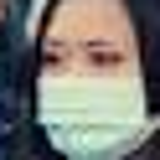

In [ ]:
load_img(TEST_PATH + 'with_mask/3.png').resize([160,160])

In [ ]:
generator = batch_generator()

In [ ]:
%time (next(generator)[0][0])

CPU times: user 143 ms, sys: 30.4 ms, total: 174 ms
Wall time: 35.1 s


<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[0.21568628, 0.12156863, 0.11372549],
        [0.21176471, 0.10980392, 0.10588235],
        [0.19607843, 0.08235294, 0.09019608],
        ...,
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294]],

       [[0.21568628, 0.12156863, 0.10980392],
        [0.21568628, 0.11372549, 0.10980392],
        [0.2       , 0.08627451, 0.09411765],
        ...,
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294]],

       [[0.21176471, 0.10980392, 0.10196079],
        [0.21176471, 0.10588235, 0.10588235],
        [0.1882353 , 0.08627451, 0.09019608],
        ...,
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294],
        [0.18431373, 0.05882353, 0.08235294]],

       ...,

       [[0.88235295, 0.8745098 , 0.90588236],
        [0.88

# Создаем модель и обучаем

## CNN

In [ ]:
# test_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(None,160,160,1)),
#     tf.keras.layers.MaxPooling2D(pool_size=2),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=2),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation=None), # No activation on final dense layer
#     tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

# ])

test_model = models.Sequential()
test_model.add(layers.Conv2D(16,(3,3), padding = 'same',activation = 'relu', input_shape = (160,160,3)))
test_model.add(layers.Conv2D(32,(3,3), padding = 'valid',activation = 'relu'))
test_model.add(layers.MaxPool2D())
test_model.add(layers.Conv2D(64,(3,3), padding = 'valid',activation = 'relu'))
test_model.add(layers.Conv2D(64,(3,3), padding = 'valid',activation = 'relu'))
test_model.add(layers.MaxPool2D())
test_model.add(layers.Conv2D(64,(3,3), padding = 'valid',activation = 'relu'))
test_model.add(layers.Flatten())
test_model.add(layers.Dense(32))
test_model.add(layers.Dense(32))
test_model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))

In [ ]:
test_model.load_weights(MODELS_PATH + r'triplet_model_best.h5')

In [ ]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 77, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 35, 35, 64)        3

In [ ]:
model_number = 2
model_name = 'triplet_model' + '_' + str(model_number)
best_w = keras.callbacks.ModelCheckpoint(MODELS_PATH + model_name + '_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                )

last_w = keras.callbacks.ModelCheckpoint(MODELS_PATH + model_name + '_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

callbacks = [best_w, last_w,early_stopping]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile the model
test_model.compile(
    optimizer=adam,
    loss=tfa.losses.TripletHardLoss(0.2))

In [ ]:
help(tfa.losses.TripletHardLoss)

Help on class TripletHardLoss in module tensorflow_addons.losses.triplet:

class TripletHardLoss(tensorflow_addons.utils.keras_utils.LossFunctionWrapper)
 |  Computes the triplet loss with hard negative and hard positive mining.
 |  
 |  The loss encourages the maximum positive distance (between a pair of embeddings
 |  with the same labels) to be smaller than the minimum negative distance plus the
 |  margin constant in the mini-batch.
 |  The loss selects the hardest positive and the hardest negative samples
 |  within the batch when forming the triplets for computing the loss.
 |  See: https://arxiv.org/pdf/1703.07737.
 |  
 |  We expect labels `y_true` to be provided as 1-D integer `Tensor` with shape
 |  [batch_size] of multi-class integer labels. And embeddings `y_pred` must be
 |  2-D float `Tensor` of l2 normalized embedding vectors.
 |  
 |  Args:
 |    margin: Float, margin term in the loss definition. Default value is 1.0.
 |    soft: Boolean, if set, use the soft margin ver

In [ ]:
epochs = 100
history = test_model.fit(batch_generator(256,'train'),
               steps_per_epoch=50,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=batch_generator(256,'validation'),
              validation_steps=10,
              use_multiprocessing=False,
              initial_epoch=0)

Epoch 1/100
50/50 [==============================] - 68s 1s/step - loss: 0.0694 - val_loss: 0.5810
Epoch 2/100
50/50 [==============================] - 68s 1s/step - loss: 0.0054 - val_loss: 0.5653
Epoch 3/100
50/50 [==============================] - 68s 1s/step - loss: 0.0011 - val_loss: 0.5463
Epoch 4/100
50/50 [==============================] - 68s 1s/step - loss: 3.2137e-04 - val_loss: 0.5959
Epoch 5/100
50/50 [==============================] - 68s 1s/step - loss: 9.2135e-05 - val_loss: 0.4101
Epoch 6/100
50/50 [==============================] - 69s 1s/step - loss: 9.4485e-05 - val_loss: 0.8736
Epoch 7/100
50/50 [==============================] - 68s 1s/step - loss: 2.5396e-05 - val_loss: 0.6327
Epoch 8/100
50/50 [==============================] - 68s 1s/step - loss: 2.3563e-05 - val_loss: 0.6484
Epoch 9/100
50/50 [==============================] - 68s 1s/step - loss: 2.1312e-06 - val_loss: 0.5710
Epoch 10/100
50/50 [==============================] - 68s 1s/step - loss: 5.1914e-05 

## Графики

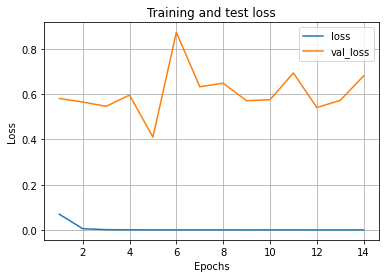

In [ ]:
epochs = 14
number = 0
training_number = '_train_' + str(number)
epochs_range = range(1,epochs+1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, loss,label = 'loss')
plt.plot(epochs_range, val_loss,label = 'val_loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig(PLOT_FOLDER_PATH + model_name + training_number + '.pdf',bbox_inches='tight')
plt.savefig(PLOT_FOLDER_PATH + model_name + training_number + '.png',bbox_inches='tight')


In [ ]:
# models.load_model(MODELS_PATH + r'triplet_model_best.h5')
test_model.load_weights(MODELS_PATH + r'triplet_model_1_best.h5')

In [ ]:
def k_nearest(x, images,labels,model,k = 5):
  predict = model.predict(images)
  x = model.predict(tf.stack([x]))
  x = tf.reshape(x, [-1,])
  confidence = 1/tf.norm(x-predict, axis = 1)
  sorted_indices = tf.argsort(confidence,direction='DESCENDING')
  # confidence = tf.reshape(confidence,[-1,1])
  # result = tf.constant([])
  
  with_mask_confidence, without_mask_confidence = tf.zeros([1]), tf.zeros([1])
  
  for index in sorted_indices[0:k]:
    print(f'Confidence {index}: {confidence[index]}')
    # print(f'with mask: {with_mask_confidence}; without mask: {without_mask_confidence}')
    if labels[index] == 1.0:
      with_mask_confidence += confidence[index]
    else:
      without_mask_confidence +=confidence[index]
  if with_mask_confidence>without_mask_confidence:
    print('with_mask')
    return 'with_mask'
  else:
    print('without_mask')
    return 'without_mask'

In [ ]:
generator = batch_generator(128,'test')
x_test,y_test = next(generator)
new_x_test,new_y_test = next(generator)

# Примеры

## Примеры с прааильными ответами

Confidence 47: 8.055251121520996
Confidence 54: 7.86305046081543
Confidence 31: 6.780327320098877
Confidence 28: 6.674094200134277
Confidence 29: 6.485001087188721
with_mask


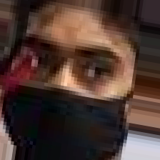

In [ ]:
i = 12
k_nearest(x_test[i],new_x_test,new_y_test,test_model,k=5)
array_to_img(x_test[i])

Confidence 61: 13.018174171447754
Confidence 60: 12.343245506286621
Confidence 40: 11.37758731842041
Confidence 2: 10.960591316223145
Confidence 49: 10.706923484802246
with_mask


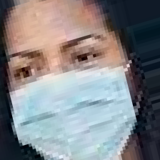

In [ ]:
i = 14
k_nearest(x_test[i],new_x_test,new_y_test,test_model,k=5)
array_to_img(x_test[i])

Confidence 68: 6.998624324798584
Confidence 86: 5.885656356811523
Confidence 118: 5.646101951599121
Confidence 76: 5.529592037200928
Confidence 108: 5.436959266662598
without_mask


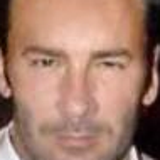

In [ ]:
i = 121
k_nearest(x_test[i],new_x_test,new_y_test,test_model,k=5)
array_to_img(x_test[i])

Confidence 107: 11.947722434997559
Confidence 99: 11.932482719421387
Confidence 75: 11.853591918945312
Confidence 114: 10.748910903930664
Confidence 127: 10.621719360351562
without_mask


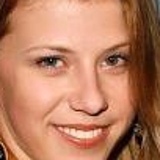

In [ ]:
i = 87
k_nearest(x_test[i],new_x_test,new_y_test,test_model,k=5)
array_to_img(x_test[i])

Confidence 37: 8.547496795654297
Confidence 47: 8.544113159179688
Confidence 18: 8.167588233947754
Confidence 34: 8.10584545135498
Confidence 23: 7.747933387756348
Confidence 49: 7.745464324951172
Confidence 50: 7.287515640258789
Confidence 40: 7.126520156860352
Confidence 57: 7.113607883453369
Confidence 7: 7.101773738861084
with_mask


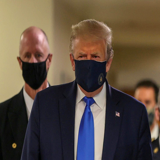

In [ ]:
x = get_image_array(IMAGES_PATH + r'trump_with_mask.jpg')
k_nearest(x,new_x_test,new_y_test,test_model,k=10)
array_to_img(x)

Confidence 45: 4.070760250091553
Confidence 1: 3.821362018585205
Confidence 56: 3.7786526679992676
Confidence 39: 3.726310968399048
Confidence 10: 3.726200580596924
Confidence 17: 3.710993528366089
Confidence 51: 3.5512073040008545
Confidence 43: 3.385129451751709
Confidence 53: 3.3702239990234375
Confidence 13: 3.3685643672943115
with_mask


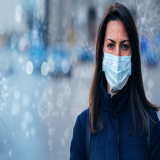

In [ ]:
x = get_image_array(IMAGES_PATH + r'person_with_mask.jpg')
k_nearest(x,new_x_test,new_y_test,test_model,k=10)
array_to_img(x)

## Примеры с неправильными ответами

Confidence 60: 8.782035827636719
Confidence 50: 8.211268424987793
Confidence 49: 7.7681756019592285
Confidence 47: 6.8631591796875
Confidence 46: 6.786459922790527
Confidence 37: 6.722461223602295
Confidence 43: 6.636939525604248
Confidence 40: 6.610143661499023
Confidence 57: 6.3786516189575195
Confidence 18: 6.113206386566162
with_mask


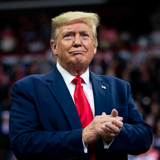

In [ ]:
x = get_image_array(IMAGES_PATH + r'trump_without_mask.jpg')
k_nearest(x,new_x_test,new_y_test,test_model,k=10)
array_to_img(x)

Confidence 5: 4.8696393966674805
Confidence 12: 4.804510116577148
Confidence 63: 4.64570951461792
Confidence 9: 4.265758514404297
Confidence 53: 4.241523265838623
Confidence 28: 4.241217613220215
Confidence 42: 4.171965599060059
Confidence 17: 3.8111417293548584
Confidence 58: 3.7368388175964355
Confidence 25: 3.7109172344207764
with_mask


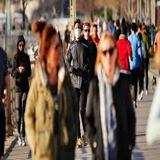

In [ ]:
x = get_image_array(IMAGES_PATH + r'people.jpg')
k_nearest(x,new_x_test,new_y_test,test_model,k=10)
array_to_img(x)